In [1]:
import numpy as np
import pandas as pd
import time
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm

main_folder_path = '/Users/glavezzi/Desktop/pyssem/pyssem'

sys.path.append(main_folder_path) 
import utils.drag.drag
importlib.reload(utils.drag.drag)
from utils.drag.drag import *

def propagate_keplerian(input_oe, param):
    """
    Propagates the orbital elements using Kepler's equation.
    
    Args:
        input_oe (numpy.ndarray): Initial orbital elements [a, e, i, RAAN, omega, M].
        param (dict): Dictionary containing parameters like mu, t, and t_0.
    
    Returns:
        numpy.ndarray: Propagated orbital elements [a, e, i, RAAN, omega, M].
    """
    mu = param['mu']
    t = param['t']
    t_0 = param['t_0']
    deg = np.pi/180

    # Extract initial orbital elements
    a = input_oe[:, 0]
    e = input_oe[:, 1]
    i = input_oe[:, 2]
    RAAN = input_oe[:, 3]
    omega = input_oe[:, 4]
    M0 = input_oe[:, 5]

    # Mean motion
    n = np.sqrt(mu) * a**(-3/2)

    M_no_wrap = M0 + n * (t - t_0)  # Mean anomaly at time t
    # M = M_no_wrap
    # if M_no_wrap > 2 * np.pi:
    M = np.mod(M_no_wrap, 2 * np.pi)  # Wrap to [0, 2*pi]
    # else: 
    #     M = M_no_/wrap

    # Update orbital elements
    propagated_oe = np.column_stack([a, e, i, RAAN, omega, M]) #np.mod(nu, 2 * np.pi)])
    return propagated_oe

def analytic_prop_vec_MOD(input_oe, param):
    # mean orbital elements propagation

    errors = np.zeros((input_oe.shape[0], 1))

    re = param['req']
    J2 = param['j2']
    mu = param['mu']

    a_0 = input_oe[:, 0]
    rho_0 = param['rho']
    C_0 = np.maximum(0.5 * param['Bstar'] * rho_0, 1e-20) # Corrected Bstar usage
    k2_over_mu = J2 * re**2 / 2  # k2 = mu*J2*re^2/2

    t = param['t']
    t_0 = param['t_0']

    e_0 = input_oe[:, 1]
    inc_0 = input_oe[:, 2]
    bigO_0 = input_oe[:, 3]
    omega_0 = input_oe[:, 4]
    Mo_0 = input_oe[:, 5]

    c = np.cos(inc_0)
    c_sq = c**2

    n_0 = np.sqrt(mu) * a_0**(-3/2)

    alpha0_sq = (e_0 / np.sqrt(a_0))**2

    beta_0 = (np.sqrt(3)/2) * e_0

    tan_atan_beta0 = np.maximum(np.tan(np.arctan(beta_0) - beta_0 * n_0 * a_0 * C_0 * (t - t_0)), 0)
    # aaa = np.tan(np.arctan(beta_0) - beta_0 * n_0 * a_0 * C_0 * (t - t_0))
    # print(f"tan_atan_beta0: {aaa[0]:.15f}")
    a = (a_0 / beta_0**2) * tan_atan_beta0**2
    e = (2/np.sqrt(3)) * tan_atan_beta0

    check_beta = beta_0 == 0
    print(beta_0)
    if np.any(check_beta):  # Avoid a=NaN when beta_0=0
        a0_beta = a_0[check_beta]
        a[check_beta] = a0_beta * (1 - C_0[check_beta] * n_0[check_beta] * a0_beta * (t - t_0))

    # Compute some variables to avoid repetition of operations
    a_sq = a**2
    four_thirds_over_a_cb = 4/3 / (a_sq * a)
    a0_sq = a_0**2
    four_thirds_over_a0_cb = 4/3 / (a0_sq * a_0)
    alpha0sq_over_asq = alpha0_sq / a_sq
    alpha0sq_over_a0sq = alpha0_sq / a0_sq

    # orig: 
    # Mo = ( (0.5/a - 0.5/a_0) + 3/8 * alpha0_sq * np.log(a/a_0) ) / C_0 + 3*k2_over_mu/16*(3*c_sq-1) * (1.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) + (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0 + Mo_0
    Mo = ( -(0.5/a - 0.5/a_0) - 3/8 * alpha0_sq * np.log(a/a_0) ) / C_0 + 3*k2_over_mu/16*(3*c_sq-1) * (1.5 * - (alpha0sq_over_asq - alpha0sq_over_a0sq) - (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0 + Mo_0

    # orig: 
    # five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 = (2.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) + (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0
    five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 = (2.5 * - (alpha0sq_over_asq - alpha0sq_over_a0sq) - (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0

    omega = 3*k2_over_mu/16 * (5*c_sq - 1) * five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 + omega_0

    bigO = -3*k2_over_mu/8 * c * five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 + bigO_0

    out_oe = np.column_stack([a, e, np.mod(inc_0, 2*np.pi), np.mod(bigO, 2*np.pi), np.mod(omega, 2*np.pi), np.mod(Mo, 2*np.pi)])

    not_real = ~np.isreal(inc_0) | ~np.isreal(bigO) | ~np.isreal(omega) | ~np.isreal(Mo)
    errors[not_real] = 1

    out_oe[not_real, :] = input_oe[not_real, :]

    return out_oe, errors

def analytic_propagation_vec(input_oe, param):
    # mean orbital elements propagation

    errors = np.zeros((input_oe.shape[0], 1))

    re = param['req']
    J2 = param['j2']
    mu = param['mu']

    a_0 = input_oe[:, 0]
    a_minus_re = a_0-re

    # if param['density_profile'] == 'jb2008':
    #     1
        # <<< from matlab, to adjust for SSEM 
        # rho = JB2008_dens_func(t, self.R0_km, self.density_data, self.date_mapping, self.nearest_altitude_mapping)
        # >>>
        # rho_0 = zeros(length(a_0),1);
        # check_above = a_minus_re>param.alt(end,1);
        # check_below = a_minus_re<param.alt(1,1);
        # check_in_range = ~check_above & ~check_below;
        # rho_0(check_in_range) = lininterp2_vec_v2(param.alt(:,1),param.dens_times(1,:),param.dens_value,a_minus_re(check_in_range), param.jd)*1e9;
        # rho_0(check_above) = lininterp1_vec(param.dens_times(1,:),param.dens_value(end,:),param.jd)*1e9;
        # rho_0(check_below) = lininterp1_vec(param.dens_times(1,:),param.dens_value(1,:),param.jd)*1e9;
    # elif param['density_profile'] == 'static':
        # rho_0 = densityexp_vec(a_minus_re)*1e9 # kg/km^3 (conversion is: [kg/m^3] or *1e9 [kg/km^3])
    rho_0 = densityexp(a_minus_re)*1e9 # kg/km^3
    # rho_0 = 1.944192087333296e-06  # kg/km^3

    C_0 = np.maximum(0.5 * param['Bstar'] * rho_0, 1e-20) # Corrected Bstar usage
    k2_over_mu = J2 * re**2 / 2  # k2 = mu*J2*re^2/2

    t = param['t']
    t_0 = param['t_0']

    e_0 = input_oe[:, 1]
    inc_0 = input_oe[:, 2]
    bigO_0 = input_oe[:, 3]
    omega_0 = input_oe[:, 4]
    Mo_0 = input_oe[:, 5]

    c = np.cos(inc_0)
    c_sq = c**2

    n_0 = np.sqrt(mu) * a_0**(-3/2)

    alpha0_sq = (e_0 / np.sqrt(a_0))**2

    beta_0 = (np.sqrt(3)/2) * e_0

    tan_atan_beta0 = np.maximum(np.tan(np.arctan(beta_0) - beta_0 * n_0 * a_0 * C_0 * (t - t_0)), 0)
    a = (a_0 / beta_0**2) * tan_atan_beta0**2
    e = (2/np.sqrt(3)) * tan_atan_beta0

    check_beta = beta_0 == 0
    if np.any(check_beta):  # Avoid a=NaN when beta_0=0
        a0_beta = a_0[check_beta]
        a[check_beta] = a0_beta * (1 - C_0[check_beta] * n_0[check_beta] * a0_beta * (t - t_0))

    # Compute some variables to avoid repetition of operations
    a_sq = a**2
    four_thirds_over_a_cb = 4/3 / (a_sq * a)
    a0_sq = a_0**2
    four_thirds_over_a0_cb = 4/3 / (a0_sq * a_0)
    alpha0sq_over_asq = alpha0_sq / a_sq
    alpha0sq_over_a0sq = alpha0_sq / a0_sq

    # orig: 
    Mo = ( (0.5/a - 0.5/a_0) + 3/8 * alpha0_sq * np.log(a/a_0) ) / C_0 + 3*k2_over_mu/16*(3*c_sq-1) * (1.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) + (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0 + Mo_0
    # Mo = ( -(0.5/a - 0.5/a_0) - 3/8 * alpha0_sq * np.log(a/a_0) ) / C_0 + 3*k2_over_mu/16*(3*c_sq-1) * (1.5 * - (alpha0sq_over_asq - alpha0sq_over_a0sq) - (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0 + Mo_0

    # orig: 
    five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 = (2.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) + (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0
    # five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 = (2.5 * - (alpha0sq_over_asq - alpha0sq_over_a0sq) - (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0

    omega = 3*k2_over_mu/16 * (5*c_sq - 1) * five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 + omega_0

    bigO = -3*k2_over_mu/8 * c * five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 + bigO_0

    out_oe = np.column_stack([a, e, np.mod(inc_0, 2*np.pi), np.mod(bigO, 2*np.pi), np.mod(omega, 2*np.pi), np.mod(Mo, 2*np.pi)])

    not_real = ~np.isreal(inc_0) | ~np.isreal(bigO) | ~np.isreal(omega) | ~np.isreal(Mo)
    errors[not_real] = 1

    out_oe[not_real, :] = input_oe[not_real, :]

    return out_oe, errors

def osc2mean_m_vec(x, param, theta_osc=None):
    """
    Converts osculating orbital elements (with mean anomaly) to mean
    orbital elements (with mean anomaly) using a vectorized approach
    and the underlying osc2mean_vec function (which presumably uses true anomaly).

    Args:
        x (numpy.ndarray): Array of osculating orbital elements.
                           Shape (N, 6) where N is the number of states.
                           x[:, 0] = osc semimajor axis (kilometers)
                           x[:, 1] = osc orbital eccentricity (non-dimensional)
                           x[:, 2] = osc orbital inclination (radians)
                           x[:, 3] = osc right ascension of ascending node (radians)
                           x[:, 4] = osc argument of perigee (radians)
                           x[:, 5] = osc mean anomaly (radians)
        param (object or dict): Parameters required by the underlying
                                osc2mean_vec function (e.g., J2, R_earth, mu).
                                This needs to be defined based on how
                                `osc2mean_vec` is implemented.
        theta_osc (numpy.ndarray, optional): Osculating true anomaly (radians).
                                            Shape (N,). If None, it will be
                                            calculated from mean anomaly.
                                            Defaults to None.

    Returns:
        tuple:
            - mean_orbital_elements (numpy.ndarray): Array of mean orbital elements.
              Shape (N, 6).
              Elements are: [a_mean, e_mean, i_mean, RAAN_mean, argp_mean, M_mean]
            - theta_mean (numpy.ndarray): Mean true anomaly (radians). Shape (N,).
            - E_mean (numpy.ndarray): Mean eccentric anomaly (radians). Shape (N,).
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1) # Ensure x is 2D for consistent indexing

    if theta_osc is None:
        # Convert from mean anomaly to true anomaly using Newton's method for Kepler's Eq.
        e_osc = x[:, 1]
        M_osc = x[:, 5] # Osculating mean anomaly
        E_osc = M_osc.copy()  # Initial guess for eccentric anomaly

        for _ in range(1000): # Max 100 iterations, typically converges much faster
            f = E_osc - e_osc * np.sin(E_osc) - M_osc
            f_prime = 1.0 - e_osc * np.cos(E_osc)
            delta_E = f / f_prime
            E_osc -= delta_E
            if np.all(np.abs(delta_E) < 1e-14): # Check for convergence
                break
        else: # Executed if the loop completes without break
            print("Warning: Newton's method for eccentric anomaly did not converge for all elements.")

        # Using the formula from MATLAB code:
        # Avoid issues with tan(E/2) when E/2 = pi/2 + k*pi
        # This can happen if E = pi, 3pi, etc.
        # If E = pi, M = pi. If M = pi, E=pi is a solution.
        # tan(pi/2) is undefined.
        # It's generally safer to use arctan2 form if possible.
        # However, to match MATLAB, we'll try this way first:
        sqrt_ep1_em1 = np.sqrt((1.0 + e_osc) / (1.0 - e_osc))
        theta_osc_calc = 2.0 * np.arctan(sqrt_ep1_em1 * np.tan(E_osc / 2.0))
        # Ensure theta_osc is in [0, 2*pi) range, np.arctan gives [-pi/2, pi/2]
        # So 2*atan gives [-pi, pi]. We need to adjust this.
        theta_osc_calc = np.mod(theta_osc_calc, 2*np.pi) # Puts it in [0, 2pi]
        theta_osc_input = theta_osc_calc
    else:
        theta_osc_input = np.asarray(theta_osc)
        if theta_osc_input.ndim == 0: # Scalar
            theta_osc_input = np.array([theta_osc_input])

    # Prepare input for osc2mean_vec: [a_osc, e_osc, i_osc, RAAN_osc, argp_osc, theta_osc_input]
    input_for_o2m_vec = np.column_stack((x[:, 0:5], theta_osc_input))
    oemean_with_theta = osc2mean_vec(input_for_o2m_vec, param)

    a_mean = oemean_with_theta[:, 0]
    e_mean = oemean_with_theta[:, 1]
    i_mean = oemean_with_theta[:, 2]
    RAAN_mean = oemean_with_theta[:, 3]
    argp_mean = oemean_with_theta[:, 4]
    theta_mean_calc = oemean_with_theta[:, 5]

    sqrt_term_inv = np.sqrt((1.0 - e_mean) / (1.0 + e_mean))
    E_mean_calc = 2.0 * np.arctan(sqrt_term_inv * np.tan(theta_mean_calc / 2.0))
    E_mean_calc = np.mod(E_mean_calc, 2 * np.pi) # Ensure E_mean is in [0, 2pi)

    # Compute mean Mean Anomaly (M_mean) from mean eccentric anomaly (E_mean_calc)
    M_mean_calc = E_mean_calc - e_mean * np.sin(E_mean_calc)
    M_mean_calc = np.mod(M_mean_calc, 2 * np.pi) # Ensure M_mean is in [0, 2pi)

    mean_orbital_elements = np.column_stack((a_mean, e_mean, i_mean,
                                             RAAN_mean, argp_mean, M_mean_calc))

    return mean_orbital_elements, theta_mean_calc, E_mean_calc

def osc2mean_vec(oeosc, param):
    """
    Converts osculating classical orbital elements to mean classical orbital elements,
    accounting for J2 secular and long-period perturbations.

    Args:
        oeosc (np.ndarray): Array of osculating orbital elements.
                            Shape (N, 6).
                            oeosc[:,0] = osc semimajor axis (kilometers)
                            oeosc[:,1] = osc orbital eccentricity (non-dimensional)
                            oeosc[:,2] = osc orbital inclination (radians)
                            oeosc[:,3] = osc right ascension of ascending node (radians)
                            oeosc[:,4] = osc argument of perigee (radians)
                            oeosc[:,5] = osc true anomaly (radians)
        param (dict): Dictionary containing parameters:
                      'req': Earth's equatorial radius (kilometers)
                      'j2': J2 gravitational coefficient (non-dimensional)
                      'mu': Earth's gravitational parameter (km^3/s^2) (optional, for kepler if needed)


    Returns:
        np.ndarray: Array of mean orbital elements. Shape (N, 6).
                    oemean[:,0] = mean semimajor axis
                    oemean[:,1] = mean orbital eccentricity
                    oemean[:,2] = mean orbital inclination
                    oemean[:,3] = mean right ascension of ascending node
                    oemean[:,4] = mean argument of perigee
                    oemean[:,5] = mean true anomaly
    """
    oeosc = np.asarray(oeosc)
    if oeosc.ndim == 1:
        oeosc = oeosc.reshape(1, -1)

    req = param['req']
    j2 = param['j2']

    pi2 = 2.0 * np.pi

    aos = oeosc[:, 0]
    eos = oeosc[:, 1]
    ios = oeosc[:, 2]
    ranos = oeosc[:, 3]
    apos = oeosc[:, 4]
    # In the MATLAB code, oeosc(:,6) is M (mean anomaly), but the comments say true anomaly.
    # The first few lines convert M to eanom (eccentric anomaly).
    # So, the input oeosc[:,5] in MATLAB was Mean Anomaly, not True Anomaly as per the top comments.
    # This script assumes the 6th element is TRUE ANOMALY as per the *input* docstring for oeosc.
    # If the 6th input element is MEAN ANOMALY, it needs to be converted to TRUE ANOMALY first.
    # The MATLAB code takes M (oeosc(:,6)) and calculates eanom, then maos.
    # Let's assume the input oeosc[:,5] is true anomaly (theta_osc) as per the docstring.
    # If it's mean anomaly (M_osc), we need this conversion first:
    # _, theta_osc = kepler1_vec_tanom(oeosc[:,5], eos) # If oeosc[:,5] is M_osc
    theta_osc = oeosc[:,5] # If oeosc[:,5] is already theta_osc

    # Convert true anomaly to eccentric anomaly
    cos_E = (eos + np.cos(theta_osc)) / (1.0 + eos * np.cos(theta_osc))
    # Ensure cos_E is within [-1, 1] due to potential floating point inaccuracies
    cos_E = np.clip(cos_E, -1.0, 1.0)
    eanom = np.arccos(cos_E)
    eanom[theta_osc > np.pi] = 2 * np.pi - eanom[theta_osc > np.pi] # Correct quadrant for E
    eanom = np.mod(eanom, pi2)

    # Mean anomaly from eccentric anomaly
    maos = np.mod(eanom - eos * np.sin(eanom), pi2)

    si2 = np.sin(ios)**2
    aa = 1.0/3.0 - 0.5 * si2
    bb = 0.5 * si2

    oemean = np.zeros_like(oeosc)

    # --- Case 1: Low eccentricity (eos < 0.01) ---
    check_e_low = eos < 0.01
    
    if np.any(check_e_low):
        aos_e = aos[check_e_low]
        eos_e = eos[check_e_low]
        ios_e = ios[check_e_low]
        ranos_e = ranos[check_e_low]
        apos_e = apos[check_e_low]
        maos_e = maos[check_e_low]
        bb_e_arr = bb[check_e_low] # Renamed from bb_e to avoid conflict

        lamos = np.mod(maos_e + apos_e, pi2)
        zos = eos_e * np.cos(apos_e)
        etaos = eos_e * np.sin(apos_e)

        # Initialize mean elements for this subset
        am_e = aos_e.copy()
        # lamm, zm, etam will be updated in the loop
        
        threej2req2 = 3.0 * j2 * req**2

        for _ in range(5): # Iteration loop
            # Precompute common terms for this iteration
            sl = np.sin(lamos) # Using lamos from previous iteration or initial
            cl = np.cos(lamos)
            s2l = np.sin(2 * lamos)
            c2l = np.cos(2 * lamos)
            s3l = np.sin(3 * lamos)
            c3l = np.cos(3 * lamos)

            asp_e_iter = threej2req2 / am_e * (bb_e_arr * c2l + (1.0 - 3.5 * bb_e_arr) * \
                           zos * cl + (1.0 - 2.5 * bb_e_arr) * etaos * sl + 3.5 * bb_e_arr * \
                           (zos * c3l + etaos * s3l))
            am_e = aos_e - asp_e_iter # Update am_e based on original aos_e
            am2_e = am_e**2
            
            threej2req2_over2_am2 = (threej2req2 / 2.0) / am2_e

            isp_e_iter = threej2req2_over2_am2 / 4.0 * np.sin(2 * ios_e) * \
                       (c2l - zos * cl + etaos * sl + (7.0/3.0) * (zos * c3l + etaos * s3l))
            im_e_iter = ios_e - isp_e_iter # Update based on original ios_e
            
            # Update terms dependent on im_e_iter for next iteration or for final use in this one
            ci = np.cos(im_e_iter)
            bb_e_arr = 0.5 * np.sin(im_e_iter)**2 # This bb_e_arr is now based on im_e_iter

            ransp_e_iter = threej2req2_over2_am2 * ci * \
                         (0.5 * s2l - 3.5 * zos * sl + 2.5 * etaos * cl + \
                          (7.0/6.0) * (zos * s3l - etaos * c3l))
            ranm_e_iter = ranos_e - ransp_e_iter # Update based on original ranos_e

            lamsp_iter = threej2req2_over2_am2 * \
                       (-0.5 * (1.0 - 5.0 * bb_e_arr) * s2l + \
                        (7.0 - (77.0/4.0) * bb_e_arr) * zos * sl - \
                        (6.0 - (55.0/4.0) * bb_e_arr) * etaos * cl - \
                        (7.0/6.0 - (77.0/12.0) * bb_e_arr) * (zos * s3l - etaos * c3l))
            lamos = np.mod(maos_e + apos_e - lamsp_iter, pi2) # Update lamos for next iteration

            s4l = np.sin(4 * lamos)
            c4l = np.cos(4 * lamos)

            zsp_iter = threej2req2_over2_am2 * \
                     ((1.0 - 2.5 * bb_e_arr) * cl + (7.0/6.0) * bb_e_arr * c3l + \
                      (1.5 - 5.0 * bb_e_arr) * zos * c2l + \
                      (2.0 - 3.0 * bb_e_arr) * etaos * s2l + \
                      (17.0/4.0) * bb_e_arr * (zos * c4l + etaos * s4l))
            zos = eos_e * np.cos(apos_e) - zsp_iter # Update zos for next iteration

            etasp_iter = threej2req2_over2_am2 * \
                       ((1.0 - 3.5 * bb_e_arr) * sl + (7.0/6.0) * bb_e_arr * s3l + \
                        (1.0 - 6.0 * bb_e_arr) * zos * s2l - \
                        (1.5 - 4.0 * bb_e_arr) * etaos * c2l + \
                        (17.0/4.0) * bb_e_arr * (zos * s4l - etaos * c4l))
            etaos = eos_e * np.sin(apos_e) - etasp_iter # Update etaos for next iteration
            
        # After loop, assign final values
        final_am_e = am_e
        final_im_e = im_e_iter
        final_ranm_e = ranm_e_iter
        final_zm = zos # zos was updated with zsp
        final_etam = etaos # etaos was updated with etasp

        em_e = np.sqrt(final_etam**2 + final_zm**2)
        apm_e = np.zeros_like(em_e)
        check_em_gt_eps = em_e > 1.0e-8
        apm_e[check_em_gt_eps] = np.arctan2(final_etam[check_em_gt_eps], final_zm[check_em_gt_eps])
        apm_e = np.mod(apm_e, pi2)

        mam_e = np.mod(lamos - apm_e, pi2) # lamos is the final updated lamm

        oemean[check_e_low, 0] = final_am_e
        oemean[check_e_low, 1] = em_e
        oemean[check_e_low, 2] = final_im_e
        oemean[check_e_low, 3] = final_ranm_e
        oemean[check_e_low, 4] = apm_e
        # The 6th element is mean true anomaly, calculated at the end for all.
        # Store mean mean anomaly for now.
        oemean[check_e_low, 5] = mam_e # Storing M_mean temporarily

    # --- Case 2: Higher eccentricity (eos >= 0.01) ---
    check_e_high = ~check_e_low
    
    if np.any(check_e_high):
        aos_note = aos[check_e_high]
        eos_note = eos[check_e_high]
        ios_note = ios[check_e_high]
        apos_note = apos[check_e_high]
        ranos_note = ranos[check_e_high]
        maos_note = maos[check_e_high] # Original mean anomaly for this subset
        theta_osc_note = theta_osc[check_e_high] # Original true anomaly for this subset

        aa_note_arr = aa[check_e_high] # Renamed
        bb_note_arr = bb[check_e_high] # Renamed

        # Initialize mean elements for iteration
        am_note = aos_note.copy()
        em_note = eos_note.copy()
        im_note = ios_note.copy()
        apm_note = apos_note.copy()
        mam_note = maos_note.copy() # This will be iterated upon
        ranm_note = ranos_note.copy() # This will be iterated upon
        
        # Initial true anomaly corresponding to initial mam_note and em_note
        _, tam_note_iter = kepler1_vec_tanom(mam_note, em_note)

        threej2req2 = 3.0 * j2 * req**2

        for _ in range(5):
            em_note2 = em_note**2
            one_minus_emnote = 1.0 - em_note2
            # Handle division by zero for e=1, though input e < 1
            one_minus_emnote = np.where(one_minus_emnote <= 0, 1e-15, one_minus_emnote)


            pm_note = am_note * one_minus_emnote
            hm = pm_note / (1.0 + em_note * np.cos(tam_note_iter))
            um = np.mod(apm_note + tam_note_iter, pi2)
            cos2um = np.cos(2 * um)
            sin2um = np.sin(2 * um)

            asp_note_iter = (threej2req2 / am_note) * \
                          (((am_note / hm)**3 * (aa_note_arr + bb_note_arr * cos2um)) - \
                           aa_note_arr * one_minus_emnote**(-1.5))
            am_note = aos_note - asp_note_iter # Update based on original aos_note

            isp_note_iter = (threej2req2 / (8.0 * pm_note**2)) * np.sin(2 * im_note) * \
                          (cos2um + em_note * np.cos(tam_note_iter + 2 * apm_note) + \
                           (1.0/3.0) * em_note * np.cos(3 * tam_note_iter + 2 * apm_note))
            im_note = ios_note - isp_note_iter # Update based on original ios_note

            si2_enote = np.sin(im_note)**2 # Using updated im_note
            aa_note_arr = 1.0/3.0 - 0.5 * si2_enote
            bb_note_arr = 0.5 * si2_enote

            # Avoid division by zero for em_note if it becomes zero
            em_note_safe = np.where(np.abs(em_note) < 1e-15, 1e-15, em_note)

            esp_note_iter = (threej2req2 / (2.0 * am_note**2)) * \
                          ((one_minus_emnote / em_note_safe * \
                            (((am_note / hm)**3 * (aa_note_arr + bb_note_arr * cos2um)) - \
                             aa_note_arr * one_minus_emnote**(-1.5))) - \
                           (bb_note_arr / (em_note_safe * one_minus_emnote)) * \
                           (cos2um + em_note * np.cos(tam_note_iter + 2 * apm_note) + \
                            em_note * np.cos(3 * tam_note_iter + 2.0 * apm_note) / 3.0))
            em_note = eos_note - esp_note_iter # Update based on original eos_note
            
            # Recompute dependent terms for next iteration or for final use
            em_note2 = em_note**2
            one_minus_emnote = 1.0 - em_note2
            one_minus_emnote = np.where(one_minus_emnote <= 0, 1e-15, one_minus_emnote)
            pm_note = am_note * one_minus_emnote
            hm = pm_note / (1.0 + em_note * np.cos(tam_note_iter)) # tam_note_iter from previous step
            
            eqoc = np.zeros_like(mam_note)
            # check_tam condition from MATLAB
            is_critical_angle = ( (np.abs(tam_note_iter - np.pi) <= 1.0e-06) | \
                                  (np.abs(mam_note - np.pi) <= 1.0e-06) | \
                                  (np.abs(tam_note_iter) <= 1.0e-06) | \
                                  (np.abs(mam_note) <= 1.0e-06) )
            eqoc[~is_critical_angle] = tam_note_iter[~is_critical_angle] - mam_note[~is_critical_angle]
            
            threej2req2_over2pm2 = (threej2req2 / 2.0) / pm_note**2

            ransp_note_iter = -threej2req2_over2pm2 * np.cos(im_note) * \
                            (eqoc + em_note * np.sin(tam_note_iter) - 0.5 * sin2um - \
                             0.5 * em_note * np.sin(tam_note_iter + 2 * apm_note) - \
                             (1.0/6.0) * em_note * np.sin(3 * tam_note_iter + 2 * apm_note))
            ranm_note = ranos_note - ransp_note_iter # Update based on original ranos_note

            # Again, use em_note_safe for division
            em_note_safe = np.where(np.abs(em_note) < 1e-15, 1e-15, em_note)

            apsp_iter = threej2req2_over2pm2 * \
                      ((2.0 - 5.0 * bb_note_arr) * (eqoc + em_note * np.sin(tam_note_iter)) + \
                       (1.0 - 3.0 * bb_note_arr) * ((1.0 - 0.25 * em_note2) * np.sin(tam_note_iter) / em_note_safe + \
                                                 0.5 * np.sin(2 * tam_note_iter) + em_note * np.sin(3 * tam_note_iter) / 12.0) - \
                       (0.5 * bb_note_arr + (0.5 - 15.0/8.0 * bb_note_arr) * em_note2) / em_note_safe * np.sin(tam_note_iter + 2 * apm_note) + \
                       em_note / 8.0 * bb_note_arr * np.sin(tam_note_iter - 2 * apm_note) - \
                       0.5 * (1.0 - 5.0 * bb_note_arr) * sin2um + \
                       (7.0/6.0 * bb_note_arr - (1.0/6.0) * em_note2 * (1.0 - 19.0/4.0 * bb_note_arr)) / em_note_safe * np.sin(3 * tam_note_iter + 2 * apm_note) + \
                       0.75 * bb_note_arr * np.sin(4 * tam_note_iter + 2 * apm_note) + \
                       em_note / 8.0 * bb_note_arr * np.sin(5 * tam_note_iter + 2 * apm_note))
            apm_note = apos_note - apsp_iter # Update based on original apos_note

            masp_iter = threej2req2_over2pm2 * np.sqrt(one_minus_emnote) / em_note_safe * \
                      (-(1.0 - 3.0 * bb_note_arr) * ((1.0 - em_note2 / 4.0) * np.sin(tam_note_iter) + \
                                                  em_note / 2.0 * np.sin(2 * tam_note_iter) + \
                                                  em_note2 / 12.0 * np.sin(3 * tam_note_iter)) + \
                       bb_note_arr * (0.5 * (1.0 + 1.25 * em_note2) * np.sin(tam_note_iter + 2 * apm_note) - \
                                   em_note2 / 8.0 * np.sin(tam_note_iter - 2 * apm_note) - \
                                   (7.0/6.0) * (1.0 - em_note2 / 28.0) * np.sin(3 * tam_note_iter + 2 * apm_note) - \
                                   0.75 * em_note * np.sin(4 * tam_note_iter + 2 * apm_note) - \
                                   em_note2 / 8.0 * np.sin(5 * tam_note_iter + 2 * apm_note)))
            mam_note = maos_note - masp_iter # Update based on original maos_note

            # Update true anomaly for the next iteration
            _, tam_note_iter = kepler1_vec_tanom(mam_note, em_note)
        
        # After loop, assign final values from this branch
        oemean[check_e_high, 0] = am_note
        oemean[check_e_high, 1] = em_note
        oemean[check_e_high, 2] = im_note
        oemean[check_e_high, 3] = ranm_note
        oemean[check_e_high, 4] = np.mod(apm_note, pi2)
        oemean[check_e_high, 5] = np.mod(mam_note, pi2) # Storing M_mean temporarily

    # --- Combine and calculate final mean true anomaly ---
    # At this point, oemean[:,5] contains the mean MEAN anomaly for all cases.
    final_M_mean = oemean[:, 5]
    final_e_mean = oemean[:, 1]
    _, final_theta_mean = kepler1_vec_tanom(final_M_mean, final_e_mean)
    oemean[:, 5] = final_theta_mean # Replace M_mean with theta_mean

    return oemean

def kepler1_vec_tanom(manom, ecc):
    """
    Solves Kepler's equation for circular, elliptic, and hyperbolic orbits
    using Danby's method (a third-order Newton-Raphson like iteration).

    Args:
        manom (np.ndarray): Mean anomaly (radians).
        ecc (np.ndarray): Orbital eccentricity (non-dimensional).

    Returns:
        tuple:
            - eanom (np.ndarray): Eccentric anomaly (radians) for elliptic orbits,
                                  or hyperbolic eccentric anomaly for hyperbolic orbits.
            - tanom (np.ndarray): True anomaly (radians).
    """
    manom = np.asarray(manom)
    ecc = np.asarray(ecc)

    if manom.shape != ecc.shape:
        if manom.size == 1 and ecc.size > 1:
            manom = np.full_like(ecc, manom.item())
        elif ecc.size == 1 and manom.size > 1:
            ecc = np.full_like(manom, ecc.item())
        else:
            raise ValueError("manom and ecc must have the same shape or one must be a scalar.")

    # Define convergence criterion
    ktol = 1.0e-10
    pi2 = 2.0 * np.pi

    # Normalize mean anomaly to [0, 2*pi)
    xma = manom - pi2 * np.floor(manom / pi2)
    # Or use np.mod(manom, pi2) if you are sure manom is always positive.
    # fix in MATLAB truncates towards zero. floor for positive numbers is the same.
    # If manom can be negative, np.fmod might be closer to MATLAB's fix for negative numbers,
    # but for anomalies, usually positive or wrapped to [0, 2pi] is expected.
    # Let's assume manom is typically positive or wrapped to positive range before this.
    # If not, use xma = np.fmod(manom, pi2); xma[xma < 0] += pi2;

    tanom = np.zeros_like(ecc)
    eanom = np.zeros_like(ecc)

    # --- Initial Guesses ---
    # Identify orbit types
    check_ecc_0 = (ecc == 0.0)
    check_ecc_lt_1_not_0 = (ecc > 0.0) & (ecc < 1.0) # Elliptic, not circular
    check_ecc_gte_1 = (ecc >= 1.0) # Hyperbolic (or parabolic if == 1)

    # Circular orbit
    if np.any(check_ecc_0):
        tanom[check_ecc_0] = xma[check_ecc_0]
        eanom[check_ecc_0] = xma[check_ecc_0]

    # Elliptic orbit initial guess
    if np.any(check_ecc_lt_1_not_0):
        eanom_ellip = eanom[check_ecc_lt_1_not_0]
        xma_ellip = xma[check_ecc_lt_1_not_0]
        ecc_ellip = ecc[check_ecc_lt_1_not_0]
        # Initial guess for elliptic eccentric anomaly
        eanom[check_ecc_lt_1_not_0] = xma_ellip + 0.85 * np.sign(np.sin(xma_ellip)) * ecc_ellip

    # Hyperbolic orbit initial guess (M_h = e_h * sinh(H) - H)
    if np.any(check_ecc_gte_1):
        eanom_hyp = eanom[check_ecc_gte_1]
        xma_hyp = xma[check_ecc_gte_1]
        ecc_hyp = ecc[check_ecc_gte_1]
        # Ensure argument of log is positive. xma_hyp can be 0.
        # log(1.8) if xma_hyp is 0 is not robust.
        # A common initial guess for H is based on M_h.
        # If M_h is small, H ~ M_h / (e-1). If M_h is large, H ~ ln(2*M_h/e)
        # The MATLAB guess log(2*M/e + 1.8) is an empirical one.
        # We need to handle xma_hyp == 0 case for log.
        # For xma_hyp == 0, H should be 0.
        arg_log = (2.0 * xma_hyp / ecc_hyp) + 1.8
        eanom_init_hyp = np.zeros_like(xma_hyp)
        eanom_init_hyp[xma_hyp > 0] = np.log(arg_log[xma_hyp > 0])
        eanom_init_hyp[xma_hyp == 0] = 0.0 # H=0 for M=0
        eanom[check_ecc_gte_1] = eanom_init_hyp


    # --- Perform Iterations (Danby's method) ---
    niter = 0
    
    # Indices for elements that still need iteration
    # We will create boolean masks for elliptic and hyperbolic cases that need iteration
    iter_mask_ellip = check_ecc_lt_1_not_0.copy()
    iter_mask_hyp = check_ecc_gte_1.copy()

    while np.any(iter_mask_ellip) or np.any(iter_mask_hyp):
        if niter > 20:
            print('\n\n   More than 20 iterations in kepler1_vec_tanom \n\n')
            # In Python, we might raise an exception or return with a warning flag
            # For now, just break, similar to MATLAB returning.
            # The final tanom will be based on the last eanom.
            break

        # --- Elliptic Case ---
        if np.any(iter_mask_ellip):
            eanom_curr_e = eanom[iter_mask_ellip]
            ecc_curr_e = ecc[iter_mask_ellip]
            xma_curr_e = xma[iter_mask_ellip]

            se = ecc_curr_e * np.sin(eanom_curr_e)
            ce = ecc_curr_e * np.cos(eanom_curr_e)

            fe = eanom_curr_e - se - xma_curr_e
            fpe = 1.0 - ce
            fppe = se
            fpppe = ce
            
            # Update eanom for elliptic cases
            delta_e = -fe / fpe
            deltastar_e = -fe / (fpe + 0.5 * delta_e * fppe)
            deltak_e = -fe / (fpe + 0.5 * deltastar_e * fppe + \
                              deltastar_e**2 * fpppe / 6.0)
            eanom[iter_mask_ellip] += deltak_e
            
            # Update mask for elliptic cases: only keep those where |fe| > ktol
            iter_mask_ellip[iter_mask_ellip] = (np.abs(fe) > ktol)


        # --- Hyperbolic Case ---
        if np.any(iter_mask_hyp):
            eanom_curr_h = eanom[iter_mask_hyp]
            ecc_curr_h = ecc[iter_mask_hyp]
            xma_curr_h = xma[iter_mask_hyp]

            sh = ecc_curr_h * np.sinh(eanom_curr_h)
            ch = ecc_curr_h * np.cosh(eanom_curr_h)

            fh = sh - eanom_curr_h - xma_curr_h # M = e*sinh(H) - H => e*sinh(H) - H - M = 0
            fph = ch - 1.0
            fpph = sh
            fppph = ch

            # Update eanom for hyperbolic cases
            # Avoid division by zero if fph is zero (ch=1 => H=0)
            # If H=0, M=0, then fh=0, so delta_h should be 0.
            delta_h = np.zeros_like(fh)
            deltastar_h = np.zeros_like(fh)
            deltak_h = np.zeros_like(fh)

            non_zero_fph = np.abs(fph) > 1e-15 # Avoid division by zero
            
            delta_h[non_zero_fph] = -fh[non_zero_fph] / fph[non_zero_fph]
            
            denom_deltastar = fph + 0.5 * delta_h * fpph
            non_zero_denom_deltastar = np.abs(denom_deltastar) > 1e-15
            deltastar_h[non_zero_denom_deltastar] = -fh[non_zero_denom_deltastar] / denom_deltastar[non_zero_denom_deltastar]
            
            denom_deltak = fph + 0.5 * deltastar_h * fpph + \
                           deltastar_h**2 * fppph / 6.0
            non_zero_denom_deltak = np.abs(denom_deltak) > 1e-15
            deltak_h[non_zero_denom_deltak] = -fh[non_zero_denom_deltak] / denom_deltak[non_zero_denom_deltak]
            
            eanom[iter_mask_hyp] += deltak_h

            # Update mask for hyperbolic cases: only keep those where |fh| > ktol
            iter_mask_hyp[iter_mask_hyp] = (np.abs(fh) > ktol)
            
        niter += 1


    # --- Compute True Anomaly ---
    # Elliptic orbit: tan(theta/2) = sqrt((1+e)/(1-e)) * tan(E/2)
    # More robustly:
    # cos(theta) = (cos(E) - e) / (1 - e*cos(E))
    # sin(theta) = (sqrt(1-e^2)*sin(E)) / (1 - e*cos(E))
    if np.any(check_ecc_lt_1_not_0):
        eanom_f_e = eanom[check_ecc_lt_1_not_0]
        ecc_f_e = ecc[check_ecc_lt_1_not_0]
        
        # Numerically stable way to calculate true anomaly from eccentric anomaly
        cos_tanom_e = (np.cos(eanom_f_e) - ecc_f_e) / (1.0 - ecc_f_e * np.cos(eanom_f_e))
        sin_tanom_e = (np.sqrt(1.0 - ecc_f_e**2) * np.sin(eanom_f_e)) / (1.0 - ecc_f_e * np.cos(eanom_f_e))
        tanom[check_ecc_lt_1_not_0] = np.arctan2(sin_tanom_e, cos_tanom_e)

    # Hyperbolic orbit: tan(theta/2) = sqrt((e+1)/(e-1)) * tanh(H/2)
    # More robustly:
    # cos(theta) = (cosh(H) - e) / (e*cosh(H) - 1) -- careful, this is for e > cosh(H)
    # A common form is:
    # cos(theta) = (e - cosh(H)) / (e*cosh(H) - 1) -> No, this is incorrect
    # Correct: cos(theta) = (ecc_hyp * np.cosh(eanom_f_h) - 1.0) / (ecc_hyp - np.cosh(eanom_f_h))
    # This seems to be for distance. Let's use the standard:
    # cos_theta = (e - cosh(H)) / (e*cosh(H) -1) is incorrect.
    # Vallado 4th ed. Eq 2-29: cos_nu = (e - cosh(H))/(e*cosh(H)-1)
    # Should be: (e - cosh(H)) / (e * cosh(H) - 1) -> No, this for cos(phi) where phi is eccentric longitude.
    # Let's use the formulation from the MATLAB code via `stah` and `ctah`
    # stah = sqrt(ecc(check_ecc_hyp) .* ecc(check_ecc_hyp) - 1) .* sinh(eanom(check_ecc_hyp));
    # ctah = ecc(check_ecc_hyp) - cosh(eanom(check_ecc_hyp));
    # This ctah is actually e - cosh(H) which is -r*cos(nu)*(e^2-1)/p for hyperbolic.
    # And stah is r*sin(nu)*(e^2-1)/p
    # So atan2(stah, ctah) should give nu.
    if np.any(check_ecc_gte_1):
        eanom_f_h = eanom[check_ecc_gte_1]
        ecc_f_h = ecc[check_ecc_gte_1]

        # Ensure e > 1 for sqrt(e^2 - 1)
        # For e=1 (parabolic), this method is not ideal. The original code doesn't special case e=1.
        # If e=1, sqrt will be 0. sinh(H) could be anything.
        # Parabolic case often uses Barker's equation. Danby's method is usually for e!=1.
        # However, the MATLAB code groups e>=1.
        ecc_f_h_safe = np.where(ecc_f_h < 1.0000000001, 1.0000000001, ecc_f_h) # Avoid e=1 issues with sqrt

        stah = np.sqrt(ecc_f_h_safe**2 - 1.0) * np.sinh(eanom_f_h)
        ctah = ecc_f_h_safe - np.cosh(eanom_f_h) # This is e - cosh(H)
        # For true anomaly, the standard relation is:
        # cos_nu = (e - cosh(H)) / (e * cosh(H) - 1) - This is incorrect.
        # cos_nu = (cosh(H) - e) / (1 - e * cosh(H))
        # sin_nu = (sqrt(e^2 - 1) * sinh(H)) / (1 - e * cosh(H))
        # The MATLAB form `atan2(stah, ctah)` implies:
        # tanom = atan2( sqrt(e^2-1)*sinh(H), e - cosh(H) )
        # This form is correct for nu.
        tanom[check_ecc_gte_1] = np.arctan2(stah, ctah)

    # Ensure tanom is in [0, 2*pi)
    tanom = np.mod(tanom, pi2)

    return eanom, tanom

def mean2osc_m_vec(x, param):
    """
    Converts mean orbital elements (with mean anomaly) to osculating
    orbital elements (with mean anomaly) using a vectorized approach
    and an underlying mean2osc_vec function (which presumably uses true anomaly).

    Args:
        x (numpy.ndarray): Array of mean orbital elements.
                           Shape (N, 6) where N is the number of states.
                           x[:, 0] = mean semimajor axis (kilometers)
                           x[:, 1] = mean orbital eccentricity (non-dimensional)
                           x[:, 2] = mean orbital inclination (radians)
                           x[:, 3] = mean right ascension of ascending node (radians)
                           x[:, 4] = mean argument of perigee (radians)
                           x[:, 5] = mean mean anomaly (radians)
        param (object or dict): Parameters required by the underlying
                                mean2osc_vec function (e.g., J2, R_earth, mu).
                                This needs to be defined based on how
                                `mean2osc_vec` is implemented.

    Returns:
        tuple:
            - osc_orbital_elements (numpy.ndarray): Array of osculating orbital elements.
              Shape (N, 6).
              Elements are: [a_osc, e_osc, i_osc, RAAN_osc, argp_osc, M_osc]
            - theta_osc (numpy.ndarray): Osculating true anomaly (radians). Shape (N,).
            - E_osc (numpy.ndarray): Osculating eccentric anomaly (radians). Shape (N,).
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1) # Ensure x is 2D for consistent indexing

    # Convert from mean mean anomaly to mean true anomaly
    e_mean = x[:, 1]
    M_mean = x[:, 5] # Mean mean anomaly
    
    # Solve Kepler's equation: M = E - e*sin(E) for E_mean
    E_mean_calc = M_mean.copy()  # Initial guess for mean eccentric anomaly
    for _ in range(1000): # Max 100 iterations
        f = E_mean_calc - e_mean * np.sin(E_mean_calc) - M_mean
        f_prime = 1.0 - e_mean * np.cos(E_mean_calc)
        delta_E = f / f_prime
        E_mean_calc -= delta_E
        if np.all(np.abs(delta_E) < 1e-14): # Check for convergence
            break
    else: # Executed if the loop completes without break
        print("Warning: Newton's method for mean eccentric anomaly did not converge for all elements.")

    # Calculate mean true anomaly (theta_mean) from mean eccentric anomaly (E_mean_calc)
    # tan(theta/2) = sqrt((1+e)/(1-e)) * tan(E/2)
    sqrt_ep1_em1_mean = np.sqrt((1.0 + e_mean) / (1.0 - e_mean))
    theta_mean_calc = 2.0 * np.arctan(sqrt_ep1_em1_mean * np.tan(E_mean_calc / 2.0))
    theta_mean_calc = np.mod(theta_mean_calc, 2 * np.pi) # Ensure theta_mean is in [0, 2pi)

    # Assume mean2osc_vec is a pre-existing Python function that takes:
    # mean_elements_with_true_anomaly (N, 6) [a_m, e_m, i_m, RAAN_m, argp_m, theta_m]
    # and param
    # and returns osc_elements_with_true_anomaly (N, 6)
    # We need to define or import mean2osc_vec
    # For now, let's create a placeholder:
    if 'mean2osc_vec' not in globals():
        def mean2osc_vec(mean_elements_theta, params_placeholder):
            """Placeholder for the actual mean2osc_vec function."""
            print("Warning: Using placeholder mean2osc_vec. Replace with actual implementation.")
            # This should implement the inverse of osc2mean_vec (e.g., inverse Brouwer-Lyddane)
            # For now, it will just pass through mean, which is incorrect for conversion
            return mean_elements_theta

    # Prepare input for mean2osc_vec: [a_mean, e_mean, i_mean, RAAN_mean, argp_mean, theta_mean_calc]
    input_for_m2o_vec = np.column_stack((x[:, 0:5], theta_mean_calc))
    oeosc_with_theta = mean2osc_vec(input_for_m2o_vec, param)

    a_osc = oeosc_with_theta[:, 0]
    e_osc_calc = oeosc_with_theta[:, 1] # osculating eccentricity
    i_osc = oeosc_with_theta[:, 2]
    RAAN_osc = oeosc_with_theta[:, 3]
    argp_osc = oeosc_with_theta[:, 4]
    theta_osc_calc = oeosc_with_theta[:, 5] # osculating true anomaly

    # Compute the osculating eccentric anomaly (E_osc_calc) from osculating true anomaly (theta_osc_calc)
    # E = 2 * atan(sqrt((1-e)/(1+e)) * tan(theta/2))
    sqrt_term_inv_osc = np.sqrt((1.0 - e_osc_calc) / (1.0 + e_osc_calc))
    E_osc_calc = 2.0 * np.arctan(sqrt_term_inv_osc * np.tan(theta_osc_calc / 2.0))
    E_osc_calc = np.mod(E_osc_calc, 2 * np.pi) # Ensure E_osc is in [0, 2pi)

    # Compute osculating Mean Anomaly (M_osc_calc) from osculating eccentric anomaly (E_osc_calc)
    M_osc_calc = E_osc_calc - e_osc_calc * np.sin(E_osc_calc)
    M_osc_calc = np.mod(M_osc_calc, 2 * np.pi) # Ensure M_osc is in [0, 2pi)

    osc_orbital_elements = np.column_stack((a_osc, e_osc_calc, i_osc,
                                            RAAN_osc, argp_osc, M_osc_calc))

    return osc_orbital_elements, theta_osc_calc, E_osc_calc


In [ ]:
# Test for anayltical prop

hours = 3600 # Hours to seconds
days = 24*hours # Days to seconds
months = 30*days # Months to seconds
years = 12*months # Years to seconds
deg = np.pi/180; # Degrees to radians

mu = 398600  # gravitational parameter in km^3/s^2
J2 = 1082.63e-6  # J2 coefficient
RE = 6378 #.136  # Earth's radius in km
cd = 2.2  # drag coefficient
A = 1 * 1e-6 # cross-sectional area in m^2 or *1e-6 for [km^2]
m = 100  # mass of the satellite in kg
B = cd*A/m
rho0 = 1.944192087333296e-06  # kg/km^3 (conversion is: [kg/m^3] or *1e9 [kg/km^3])

t0 = 0
nout = 30*days
tf = 1*12*30*days
t2 = np.arange(t0, tf + nout * 0.001, nout)

param = {
    'req': RE,    
    'j2': J2 * 1,
    'mu': mu,
    'Bstar': B * 1, 
    'density_profile': 'static', 
    't_0': 0, 
    't': 0           
}

# Spacecraft properties
i0 = 45*deg # Inclination (radians) 
RA0 = 30*deg # Right ascension of the node (radians)
w0 = 10*deg # Argument of perigee (radians)
TA0 = 50*deg # True anomaly (radians)

rp0 = RE + 550 # perigee radius (km)
ra0 = RE + 700 # apogee radius (km)
e0 = (ra0 - rp0)/(ra0 + rp0) # eccentricity
a0 = (rp0 + ra0)/2 # Semimajor axis (km)

input_oe = [a0, e0, i0, RA0, w0, TA0]

mean_orbital_elements, _, _ = osc2mean_m_vec(input_oe, param, TA0)
input_oe = mean_orbital_elements

print(f"{input_oe[0][0]:.15e}")  # For the first number in scientific notation
print(f"{input_oe[0][1]:.15f}")  # For the second in fixed-point
print(f"{input_oe[0][2]:.15f}")
print(f"{input_oe[0][3]:.15f}")
print(f"{input_oe[0][4]:.15f}")
print(f"{input_oe[0][5]:.15f}")
print("-" * 20)

out_oe = np.zeros((len(t2) - 1, 6))
errors = np.zeros((len(t2) - 1, 1))

start_time = time.time()
for i1 in range(len(t2) - 1):
    if input_oe[0][0] * (1 - input_oe[0][1]) < RE + 200:
        out_oe[i1, :] = out_oe[i1 - 1, :]
    else:
        param['t_0'] = t2[i1]
        param['t'] = t2[i1 + 1]

        propagated_elements, error_value = analytic_propagation_vec(input_oe, param)
        
        out_oe[i1, :] = propagated_elements
        errors[i1, 0] = error_value
        input_oe[0][:] = out_oe[i1, :].copy()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"{out_oe[-1][0]:.15e}")  # For the first number in scientific notation
print(f"{out_oe[-1][1]:.15f}")  # For the second in fixed-point
print(f"{out_oe[-1][2]:.15f}")
print(f"{out_oe[-1][3]:.15f}")
print(f"{out_oe[-1][4]:.15f}")
print(f"{out_oe[-1][5]:.15f}")
print("-" * 20)


7.005376920470177e+03
0.010826279447580
0.785566494115020
0.523205520324073
0.159069317918465
0.871630625664513
--------------------
7.001700750593673e+03
0.010823438453761
0.785566494115020
0.029321599115036
2.575312524590355
2.442632601066016
--------------------


/var/folders/8r/pmy63vtd1lbbfd8ptmtgcr4w0000gn/T/ipykernel_44184/98704348.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errors[i1, 0] = error_value


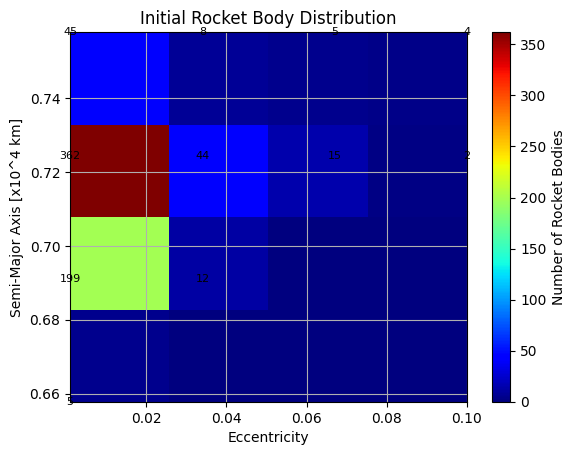

IndexError: invalid index to scalar variable.

In [8]:
hours = 3600.0
days = 24.0 * hours
months = 30.0 * days
years = 12.0 * months
deg = np.pi / 180.0

mu = 398600.0
RE = 6378.136
J2 = 1082.63e-6

i0 = 45.0 * deg
RA0 = 0.0 * deg
w0 = 0.0 * deg
TA0 = 0.0 * deg
A = 1.0 * 1e-6
m = 100.0
cd = 2.2
B = cd * A / m
param = {}
param['req'] = RE
param['j2'] = J2 
param['mu'] = mu
param['Bstar'] = B
param['density_profile'] = 'static'

n_points = 4

sma_max = 1200.0 + RE
sma_min = 200.0 + RE
ecc_max = 0.1
ecc_min = 0.001

semi_major_axis_points = np.linspace(sma_min, sma_max, n_points)
eccentricity_points = np.linspace(ecc_min, ecc_max, n_points)

filename = 'x0.csv'
data = pd.read_csv(filename)

filtered_data = data[data['species_class'] == 'B'].copy()

valid_indices_mask = (filtered_data['sma'] >= sma_min) & \
                     (filtered_data['sma'] <= sma_max) & \
                     (filtered_data['ecc'] >= ecc_min) & \
                     (filtered_data['ecc'] <= ecc_max)
filtered_data = filtered_data[valid_indices_mask]

sma_points = filtered_data['sma'].values
ecc_points = filtered_data['ecc'].values
adept_ids = filtered_data['adept_id'].values

time_step = 7.0 * days
total_time = 1.0 * years
# years_in_seconds = np.array([10.0, 40.0, 70.0, 100.0]) * years
years_in_seconds = np.array([0.0, 0.3, 0.7, 1.0]) * years

num_steps_times = np.arange(0, total_time + time_step, time_step) # Ensure total_time is included

num_bodies = len(sma_points)
sma_trajectory = np.zeros((num_bodies, len(num_steps_times)))
ecc_trajectory = np.zeros((num_bodies, len(num_steps_times)))


valid_indices_plot_initial = (sma_points >= sma_min) & (sma_points <= sma_max) & \
                             (ecc_points >= ecc_min) & (ecc_points <= ecc_max)

valid_sma_initial = sma_points[valid_indices_plot_initial]
valid_ecc_initial = ecc_points[valid_indices_plot_initial]

distribution_matrix_initial = np.zeros((n_points, n_points))

for i in range(len(valid_sma_initial)):
    sma_idx = np.argmin(np.abs(semi_major_axis_points - valid_sma_initial[i]))
    ecc_idx = np.argmin(np.abs(eccentricity_points - valid_ecc_initial[i]))
    distribution_matrix_initial[sma_idx, ecc_idx] += 1

plt.figure()
plt.imshow(distribution_matrix_initial, extent=[eccentricity_points[0], eccentricity_points[-1],
                                semi_major_axis_points[0]/10000, semi_major_axis_points[-1]/10000],
           origin='lower', aspect='auto', cmap='jet', interpolation='nearest')
plt.colorbar(label='Number of Rocket Bodies')
plt.title('Initial Rocket Body Distribution')
plt.xlabel('Eccentricity')
plt.ylabel('Semi-Major Axis [x10^4 km]')
plt.grid(True)

for i in range(n_points):
    for j in range(n_points):
        if distribution_matrix_initial[i, j] > 0:
            x_pos = eccentricity_points[j]
            y_pos = semi_major_axis_points[i] / 10000.0
            plt.text(x_pos, y_pos, f"{distribution_matrix_initial[i, j]:.0f}",
                     horizontalalignment='center', verticalalignment='center',
                     fontsize=8, color='k')
plt.show(block=False)


start_prop_time = time.time()
for i in range(num_bodies):
    input_oe_current = np.array([sma_points[i], ecc_points[i], i0, RA0, w0, TA0])
    # mean_orbital_elements, _, _ = osc2mean_m_vec(input_oe_current, param, TA0) # TA0 is osculating true anomaly
    # input_oe_current = mean_orbital_elements

    sma_trajectory[i, 0] = input_oe_current[0][0]
    ecc_trajectory[i, 0] = input_oe_current[0][1]
    # out_oe_body = np.zeros((len(num_steps_times) - 1, 6)) # This was per body in MATLAB, not strictly needed if input_oe_current is updated

    for j in range(len(num_steps_times) - 1):
        if input_oe_current[0][0] * (1 - input_oe_current[0][1]) < RE + 150.0 or input_oe_current[0][0] < 100.0:
            sma_trajectory[i, j + 1:] = -99.0
            ecc_trajectory[i, j + 1:] = -99.0
            # out_oe_body[j,:] = out_oe_body[j-1,:] # If out_oe_body was used
            break
        else:
            param['t_0'] = num_steps_times[j]
            param['t'] = num_steps_times[j + 1]

            out_oe_propagated, _ = analytic_propagation_vec(input_oe_current, param)
            # out_oe_body[j,:] = out_oe_propagated # If out_oe_body was used
            input_oe_current = out_oe_propagated
        
        sma_trajectory[i, j + 1] = input_oe_current[0][0]
        ecc_trajectory[i, j + 1] = input_oe_current[0][1]
end_prop_time = time.time()
print(f"Propagation elapsed time: {end_prop_time - start_prop_time:.2f} seconds")


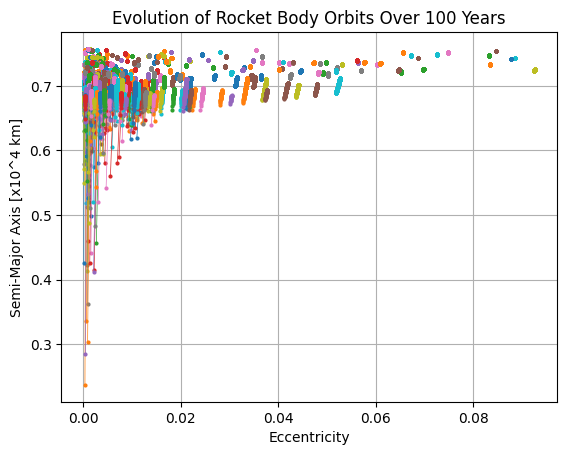

/var/folders/8r/pmy63vtd1lbbfd8ptmtgcr4w0000gn/T/ipykernel_44184/1341911440.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  current_cmap = cm.get_cmap('jet').copy() # Get a copy of the colormap


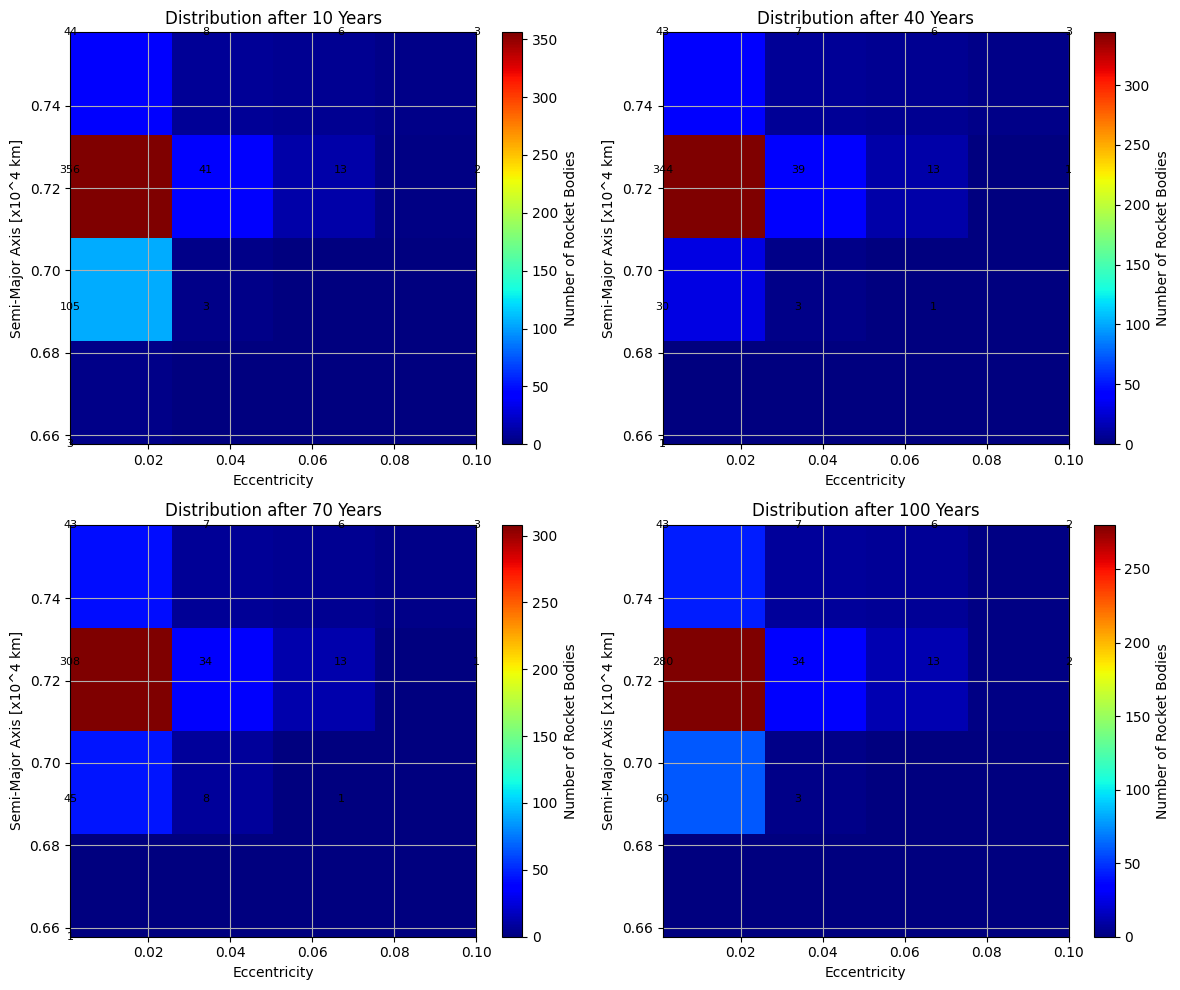

In [157]:
plt.figure()
for i in range(num_bodies):
    valid_trajectory_indices = (sma_trajectory[i, :] != -99.0) & (ecc_trajectory[i, :] != -99.0)
    if np.any(valid_trajectory_indices):
        plt.plot(ecc_trajectory[i, valid_trajectory_indices], 
                 sma_trajectory[i, valid_trajectory_indices] / 10000.0, 
                 '-o', markersize=2, linewidth=0.5) # Adjusted for better visibility with many lines
plt.xlabel('Eccentricity')
plt.ylabel('Semi-Major Axis [x10^4 km]')
plt.title('Evolution of Rocket Body Orbits Over 100 Years')
plt.grid(True)
plt.show(block=False)


time_indices_to_plot = np.array([np.argmin(np.abs(num_steps_times - t)) for t in years_in_seconds])

plt.figure(figsize=(12, 10))
num_plots = len(time_indices_to_plot)

for k_idx, t_idx_val in enumerate(time_indices_to_plot):
    if not (0 <= t_idx_val < len(num_steps_times)):
        print(f'Error: Invalid time index: {t_idx_val} for year {years_in_seconds[k_idx]/years}')
        continue
    
    distribution_matrix_t = np.zeros((n_points, n_points))
    
    valid_bodies_at_t = (sma_trajectory[:, t_idx_val] != -99.0) & (ecc_trajectory[:, t_idx_val] != -99.0)
    
    valid_sma_t = sma_trajectory[valid_bodies_at_t, t_idx_val]
    valid_ecc_t = ecc_trajectory[valid_bodies_at_t, t_idx_val]
    
    for i in range(len(valid_sma_t)):
        sma_idx = np.argmin(np.abs(semi_major_axis_points - valid_sma_t[i]))
        ecc_idx = np.argmin(np.abs(eccentricity_points - valid_ecc_t[i]))
        distribution_matrix_t[sma_idx, ecc_idx] += 1
    
    plt.subplot(2, 2, k_idx + 1)
    
    current_cmap = cm.get_cmap('jet').copy() # Get a copy of the colormap
    current_cmap.set_bad(color='white') # Set color for NaN or masked values if used
                                        # For zeros, we want the lowest color of jet.
                                        # To make zero values white if desired and not part of data range:
                                        # distribution_matrix_t_masked = np.ma.masked_equal(distribution_matrix_t, 0)
                                        # plt.imshow(distribution_matrix_t_masked, ...)
                                        # Or set the under color if vmin is slightly > 0
    
    plt.imshow(distribution_matrix_t, 
               extent=[eccentricity_points[0], eccentricity_points[-1],
                       semi_major_axis_points[0]/10000.0, semi_major_axis_points[-1]/10000.0],
               origin='lower', aspect='auto', cmap=current_cmap, interpolation='nearest')
    plt.colorbar(label='Number of Rocket Bodies')
    
    plt.title(f'Distribution after {num_steps_times[t_idx_val]/years:.0f} Years')
    plt.xlabel('Eccentricity')
    plt.ylabel('Semi-Major Axis [x10^4 km]')
    plt.grid(True)
    
    for i_row in range(n_points):
        for j_col in range(n_points):
            if distribution_matrix_t[i_row, j_col] > 0:
                x_pos = eccentricity_points[j_col]
                y_pos = semi_major_axis_points[i_row] / 10000.0
                plt.text(x_pos, y_pos, f"{distribution_matrix_t[i_row, j_col]:.0f}",
                         horizontalalignment='center', verticalalignment='center',
                         fontsize=8, color='k')

plt.tight_layout()
plt.show()

In [41]:
# Test for elliptical orbit in pyssem

hours = 3600 # Hours to seconds
days = 24*hours # Days to seconds
months = 30*days # Months to seconds
years = 12*months # Years to seconds
deg = np.pi/180; # Degrees to radians

mu = 398600  # gravitational parameter in km^3/s^2
J2 = 1082.63e-6  # J2 coefficient
RE = 6378 #.136  # Earth's radius in km
cd = 2.2  # drag coefficient
A = 1 * 1e-6 # cross-sectional area in m^2 or *1e-6 for [km^2]
m = 100  # mass of the satellite in kg
B = cd*A/m
rho0 = 1.944192087333296e-06  # kg/km^3 (conversion is: [kg/m^3] or *1e9 [kg/km^3])

dt = 1

param = {
    'req': RE,    
    'j2': J2 * 1,
    'mu': mu,
    'Bstar': B * 1, 
    'rho': rho0, 
    't_0': 0, 
    't': dt           
}

# Spacecraft properties
i0 = 45*deg # Inclination (radians) 
RA0 = 0*deg # Right ascension of the node (radians)
w0 = 0*deg # Argument of perigee (radians)
TA0 = 400*deg # True anomaly (radians)

rp0 = RE + 550 # perigee radius (km)
ra0 = RE + 1750 # apogee radius (km)
e0 = (ra0 - rp0)/(ra0 + rp0) # eccentricity
a0 = (rp0 + ra0)/2 # Semimajor axis (km)

input_oe = [a0, e0, i0, RA0, w0, TA0]

# h = np.sqrt(input_oe[0] * (1 - input_oe[1]**2) * mu)
# r = (h**2 / mu) / (1 + e0 * np.cos(input_oe[5]))

mean_orbital_elements, _, _ = osc2mean_m_vec(input_oe, param, TA0)
input_oe = mean_orbital_elements

print(f"{input_oe[0][0]:.15e}")  # For the first number in scientific notation
print(f"{input_oe[0][1]:.15f}")  # For the second in fixed-point
print(f"{input_oe[0][2]:.15f}")
print(f"{input_oe[0][3]:.15f}")
print(f"{input_oe[0][4]:.15f}")
print(f"{input_oe[0][5]:.15f}")
print("-" * 20)
# --------------------
# rp0 = RE + 550 # perigee radius (km)
# ra0 = RE + 1750 # apogee radius (km)
# i0 = 45*deg # Inclination (radians) 
# RA0 = 20*deg # Right ascension of the node (radians)
# w0 = 10*deg # Argument of perigee (radians)
# TA0 = 30*deg # True anomaly (radians)
# --------------------
# matlab
# 7.526711835500698e+03
# 0.079427650521734
# 0.785334547232223
# 0.348716031002880
# 0.169490511304498
# 0.452629383724775
# --------------------
# python
# 7.526711835499988e+03
# 0.079427650520449
# 0.785334547232407
# 0.348716031003144
# 0.169490511305290
# 0.452629383723730
# --------------------


7.526772702644555e+03
0.079499537733263
0.785332859647958
0.000316897879973
0.005453514312702
5.677816078515050
--------------------


In [ ]:
# Test for Operational Feasibility work

mu = 398600  # gravitational parameter in km^3/s^2
J2 = 1082.63e-6  # J2 coefficient
RE = 6378  # Earth's radius in km
cd = 2.2  # drag coefficient
A = 1 * 1e-6 # cross-sectional area in m^2 or *1e-6 for [km^2]
m = 100  # mass of the satellite in kg
B = cd*A/m
rho0 = 1.944192087333296e-06  # kg/km^3 (conversion is: [kg/m^3] or *1e9 [kg/km^3])

from_matlab1 = [7507.6290061995,
         0.116640408348328,
         0.785703852208281,
         0.174930790861768,
         0.524936882311218,
          1.00779162406823]

from_matlab2 = [6782.58140364874,
      0.000220331022356249,
         0.785735620099787,
         0.174706236385514,
          2.12610210614672,
        -0.380710999149193]

from_matlab3 = [7511.88131938137,
         0.117050755060748,
          1.91966574138367,
         0.174340452911236,
         0.534316518462145,
         0.999012283321003]

from_matlab4 = [7011.49667759347,
        0.0539825302809328,
          1.91965033679686,
          3.66504862488471,
         0.548835656769462,
          1.09760204144139]

from_matlab5 = [7009.74059936841,
         0.025450330656246,
          1.91969154363248,
          1.92003970020848,
          2.22302522140705,
        -0.958973564267631]

from_matlab = from_matlab1

# Initial Mean Orbital Elements (from MATLAB)
a0 = from_matlab[0] # initial semi-major axis in km
e0 = from_matlab[1] # initial eccentricity
i0 = from_matlab[2]  # initial inclination in radians
Omega0 = from_matlab[3]  # initial right ascension of ascending node in radians
omega0 = from_matlab[4]  # initial argument of perigee in radians
M0 = from_matlab[5]  # initial mean anomaly in radians
input_oe = np.array([[a0, e0, i0, Omega0, omega0, M0]])

t0 = pd.Timestamp('2023-01-01 00:00:00')  # initial time
t = pd.Timestamp('2023-01-01 00:00:00.1')  # final time
dt = (t - t0).total_seconds()

param = {
    'req': RE,    
    'j2': J2 * 0,
    'mu': mu,
    'Bstar': B * 0, 
    'rho': rho0, 
    't_0': 0, 
    't': dt           
}

# Propagate the mean orbital elements
out_oe, _ = analytic_prop_vec_MOD(input_oe,param)

# Print the results
deg = np.pi/180  # convert radian to degree, if necessary

print("Initial Mean Orbital Elements:")
print(f"  sma: {input_oe[:,0][0]:.3f} km")
print(f"  e: {input_oe[:,1][0]:.6f}")
print(f"  incl: {input_oe[:,2][0]/deg:.6f} deg")
print(f"  RAAN: {input_oe[:,3][0]/deg:.6f} deg")
print(f"  arg_per: {input_oe[:,4][0]/deg:.6f} deg")
print(f"  mean_anom: {input_oe[:,5][0]/deg:.6f} deg")

print("\n")  # Print a blank line

print("Final Mean Orbital Elements:")
print(f"  sma: {out_oe[:,0][0]:.3f} km")
print(f"  e: {out_oe[:,1][0]:.6f}")
print(f"  incl: {out_oe[:,2][0]/deg:.6f} deg")
print(f"  RAAN: {out_oe[:,3][0]/deg:.6f} deg")
print(f"  arg_per: {out_oe[:,4][0]/deg:.6f} deg")
print(f"  mean_anom: {out_oe[:,5][0]/deg:.6f} deg")
# Note: The above code assumes that the atmospheric density rho0 is constant.

# # output using from_matlab1 as initial conditions
# Initial Mean Orbital Elements:
#   sma: 7507.629 km
#   e: 0.116640
#   incl: 45.017515 deg
#   RAAN: 10.022796 deg
#   arg_per: 30.076668 deg
#   mean_anom: 57.742207 deg
# Final Mean Orbital Elements:
#   sma: 7507.629 km
#   e: 0.116640
#   incl: 45.017515 deg
#   RAAN: 5.933295 deg
#   arg_per: 34.411144 deg
#   mean_anom: 183.204813 deg

# # output using from_matlab2 as initial conditions
# Initial Mean Orbital Elements:
#   sma: 6782.581 km
#   e: 0.000220
#   incl: 45.019335 deg
#   RAAN: 10.009930 deg
#   arg_per: 121.816677 deg
#   mean_anom: -21.813133 deg
# Final Mean Orbital Elements:
#   sma: 6782.582 km
#   e: 0.000220
#   incl: 45.019335 deg
#   RAAN: 4.330546 deg
#   arg_per: 127.835829 deg
#   mean_anom: 175.351075 deg

[0.10101356]
Initial Mean Orbital Elements:
  sma: 7507.629 km
  e: 0.116640
  incl: 45.017515 deg
  RAAN: 10.022796 deg
  arg_per: 30.076668 deg
  mean_anom: 57.742207 deg


Final Mean Orbital Elements:
  sma: 7507.629 km
  e: 0.116640
  incl: 45.017515 deg
  RAAN: 10.022796 deg
  arg_per: 30.076668 deg
  mean_anom: 57.742207 deg


In [ ]:
from_matlab1 = [6682.70631579479,
      0.000230723598916234,
         0.785749989047153,
          0.17469421897602,
          2.06451203498031,
        -0.336578490605857]

from_matlab2 = [6782.58140364874,
      0.000220331022356249,
         0.785735620099787,
         0.174706236385514,
          2.12610210614672,
        -0.380710999149193]

from_matlab = from_matlab2

# Initial Mean Orbital Elements (from MATLAB)
a0 = from_matlab[0] # initial semi-major axis in km
e0 = from_matlab[1] # initial eccentricity
i0 = from_matlab[2]  # initial inclination in radians
Omega0 = from_matlab[3]  # initial right ascension of ascending node in radians
omega0 = from_matlab[4]  # initial argument of perigee in radians
M0 = from_matlab[5]  # initial mean anomaly in radians
input_oe = np.array([[a0, e0, i0, Omega0, omega0, M0]])

t0 = pd.Timestamp('2023-01-01 00:00:00')  # initial time
t = pd.Timestamp('2023-01-01 00:00:01')  # final time
dt = (t - t0).total_seconds()

param = {
    'req': RE,    
    'j2': J2 * 0,
    'mu': mu,
    'Bstar': B * 0, 
    'rho': rho0, 
    't': dt, 
    't_0': 0,        
}

# Propagate the mean orbital elements
start_time = time.time()
out_oe, _ = analytic_prop_vec_MOD(input_oe, param)
end_time = time.time()

print(f"Cpu time (analytical): {end_time - start_time:.6f} seconds")

start_time = time.time()
out_oe_kep = propagate_keplerian(input_oe, param)
end_time = time.time()

print(f"Cpu time (kepler): {end_time - start_time:.6f} seconds\n")

# Print the results
deg = np.pi/180  # convert radian to degree, if necessary

print("Initial Mean Orbital Elements:")
print(f"  sma: {input_oe[:,0][0]:.3f} km")
print(f"  e: {input_oe[:,1][0]:.6f}")
print(f"  incl: {input_oe[:,2][0]/deg:.6f} deg")
print(f"  RAAN: {input_oe[:,3][0]/deg:.6f} deg")
print(f"  arg_per: {input_oe[:,4][0]/deg:.6f} deg")
print(f"  mean_anom: {input_oe[:,5][0]/deg:.6f} deg\n")

# print("\n")  # Print a blank line

print("Final Mean Orbital Elements:")
print(f"  sma: {out_oe[:,0][0]:.3f} km")
print(f"  e: {out_oe[:,1][0]:.6f}")
print(f"  incl: {out_oe[:,2][0]/deg:.6f} deg")
print(f"  RAAN: {out_oe[:,3][0]/deg:.6f} deg")
print(f"  arg_per: {out_oe[:,4][0]/deg:.6f} deg")
print(f"  mean_anom analytical: {out_oe[:,5][0]/deg:.6f} deg")
print(f"  mean_anom keplerian: {out_oe_kep[:,5][0]/deg:.6f} deg")


[0.00019081]
Cpu time (analytical): 0.000953 seconds
Cpu time (kepler): 0.000053 seconds

Initial Mean Orbital Elements:
  sma: 6782.581 km
  e: 0.000220
  incl: 45.019335 deg
  RAAN: 10.009930 deg
  arg_per: 121.816677 deg
  mean_anom: -21.813133 deg

Final Mean Orbital Elements:
  sma: 6782.581 km
  e: 0.000220
  incl: 45.019335 deg
  RAAN: 10.009930 deg
  arg_per: 121.816677 deg
  mean_anom analytical: 55.837124 deg
  mean_anom keplerian: 338.251625 deg
